In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# {'ARID3A' : 0, 'CTCFL' : 1, 'ELK1' : 2, 'FOXA1' : 3, 'GABPA' : 4, 'MYC' : 5, 'REST' : 6, 'SP1' : 7, 'USF1' : 8, 'ZBTB7A' : 9}
TF_name = 'ZBTB7A'
path = '../Models/'+TF_name+'/reproduction/best_model.pth'

In [3]:
class ConvNet_Base(nn.Module):
    def __init__(self,nummotif,motiflen,poolType,mode,learning_rate,dropprob,device):
        super(ConvNet_Base, self).__init__()
        self.device = device
        self.poolType=poolType
        self.mode=mode
        self.learning_rate=learning_rate
        self.dropprob=dropprob
        # for conv1
        self.wConv1=torch.randn(nummotif,4,motiflen).to(device)
        torch.nn.init.xavier_uniform_(self.wConv1)
        self.wConv1.requires_grad=True
        self.wRect1=torch.randn(nummotif).to(device)
        torch.nn.init.normal_(self.wRect1)
        self.wRect1=-self.wRect1
        self.wRect1.requires_grad=True
        # for conv2
        self.wConv2=torch.randn(nummotif,nummotif,motiflen).to(device)
        torch.nn.init.xavier_uniform_(self.wConv2)
        self.wConv2.requires_grad=True
        self.wRect2=torch.randn(nummotif).to(device)
        torch.nn.init.normal_(self.wRect1)
        self.wRect2=-self.wRect2
        self.wRect2.requires_grad=True

    def forward_pass(self,x,mask=None,use_mask=False):
        # conv1
        conv1 = F.conv1d(x, self.wConv1, bias=self.wRect1, stride=1, padding=0)
        rect1 = conv1.clamp(min=0)
        # conv2
        conv2 = F.conv1d(rect1, self.wConv2, bias=self.wRect2, stride=1, padding=0)
        rect2 = conv2.clamp(min=0)
        maxPool, _ = torch.max(rect2, dim=2)
        if self.poolType=='maxavg':
            avgPool = torch.mean(rect2, dim=2)                     
            pool = torch.cat((maxPool, avgPool), 1)
        else:
            pool = maxPool
        return pool
       
    def forward(self, x):
        out =self.forward_pass(x)
        return out

In [4]:
state_dict = torch.load(path)

In [5]:
print(state_dict.keys())

dict_keys(['conv1', 'rect1', 'conv2', 'rect2', 'wHidden', 'wHiddenBias', 'wNeu', 'wNeuBias'])


In [6]:
nummotif = 16
motif_len = 24
mode = 'test'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dummy_pool = 'max'
dummy_lr = '0.05'
dummy_dropprob = 1.0

In [7]:
model = ConvNet_Base(nummotif,motif_len,dummy_pool,mode,dummy_lr,dummy_dropprob,device).to(device)

In [8]:
model.wConv1 = state_dict['conv1']
model.wRect1 = state_dict['rect1']
model.wConv2 = state_dict['conv2']
model.wRect2 = state_dict['rect2']

In [9]:
import os
import csv
import gzip
import math
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader

DNAbases='ACGT' # DNA bases

def datasets(file_path):
    '''
    Input : path to the datasets

    Output : list of dataset names 

        dataset_names[i][0] for list of AC.seq.gz datasets

        dataset_names[i][1] for list of B.seq.gz datasets
    '''
    path = file_path
    files = os.listdir(path)

    train = []
    test = []
    dataset_names = []

    for file in files:
        if file.endswith("AC.seq.gz"):
            train.append(path+file)
        elif file.endswith("B.seq.gz"):
            test.append(path+file)

    train.sort()
    test.sort()

    if(len(train) != len(test)):
        raise Exception("Dataset Corrputed. Please Download The Dataset Again")

    for i in range(len(train)):
        dataset_names.extend([[train[i], test[i]]])

    return dataset_names
def seqtopad(seq,motif_len):
    rows=len(seq)+2*motif_len-2
    S=np.empty([rows,4])
    base= DNAbases 
    for i in range(rows):
        for j in range(4):
            if i-motif_len+1<len(seq) and seq[i-motif_len+1]=='N' or i<motif_len-1 or i>len(seq)+motif_len-2:
                S[i,j]=np.float32(0.25)
            elif seq[i-motif_len+1]==base[j]:
                S[i,j]=np.float32(1)
            else:
                S[i,j]=np.float32(0)
    return np.transpose(S)

def dinuc_shuffling(seq):
    b=[seq[i:i+2] for i in range(0, len(seq), 2)]
    random.shuffle(b)
    d=''.join([str(x) for x in b])
    return d

def complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N': 'N'}
    complement_seq = [complement[nt] for nt in seq] # nt stands for nucleotide
    return complement_seq
  
def reverse_complement(seq):
    seq = list(seq)
    seq.reverse()
    return ''.join(complement(seq))

class Chip_test():
    def __init__(self,filename,motif_len):
        self.file = filename
        self.motif_len = motif_len
            
    def openFile(self):
        test_dataset=[]
        with gzip.open(self.file, 'rt') as data:
            next(data)
            reader = csv.reader(data,delimiter='\t')

            for row in reader:
                test_dataset.append([seqtopad(row[2],self.motif_len),[int(row[3])]])
       
        return test_dataset

class chipseq_dataset(Dataset):
    def __init__(self,xy=None):
        self.x_data=np.asarray([el[0] for el in xy],dtype=np.float32)
        self.y_data =np.asarray([el[1] for el in xy ],dtype=np.float32)
        self.x_data = torch.from_numpy(self.x_data)
        self.y_data = torch.from_numpy(self.y_data)
        self.len=len(self.x_data)
      
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

def test_dataset_loader(filepath, motif_len):
    chipseq_test=Chip_test(filepath, motif_len)
    test_data=chipseq_test.openFile()

    test_dataset=chipseq_dataset(test_data)
    batchSize=test_dataset.__len__() # at once

    test_loader = DataLoader(dataset=test_dataset,batch_size=batchSize,shuffle=False)

    return test_loader

In [10]:
path = '../data/encode/'
all_dataset_names = datasets(path)
TF2idx = {'ARID3A' : 0, 'CTCFL' : 1, 'ELK1' : 2, 'FOXA1' : 3, 'GABPA' : 4, 'MYC' : 5, 'REST' : 6, 'SP1' : 7, 'USF1' : 8, 'ZBTB7A' : 9}
TFidx = TF2idx[TF_name]
dataset_name = all_dataset_names[TFidx]
train_dataset_path = dataset_name[0]
test_dataset_path = dataset_name[1]

In [11]:
print(train_dataset_path)
print(test_dataset_path)

../data/encode/ZBTB7A_HepG2_ZBTB7A_(SC-34508)_HudsonAlpha_AC.seq.gz
../data/encode/ZBTB7A_HepG2_ZBTB7A_(SC-34508)_HudsonAlpha_B.seq.gz


In [12]:
train_loader = test_dataset_loader(train_dataset_path, motif_len)
test_loader = test_dataset_loader(test_dataset_path, motif_len)

In [13]:
train = None
test = None
train_target = None
test_target = None

for idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)

    # Forward pass
    train = model.forward(data)
    train_target = target

for idx, (data, target) in enumerate(test_loader):
    data = data.to(device)
    target = target.to(device)

    # Forward pass
    test = model.forward(data)
    test_target = target

In [14]:
print(train.shape)
print(test.shape)

torch.Size([8689, 16])
torch.Size([1000, 16])


In [15]:
train = train.cpu().detach().numpy()
test = test.cpu().detach().numpy()
train_target = train_target.cpu().detach().numpy()
test_target = test_target.cpu().detach().numpy()

In [16]:
print(train.shape)
print(test.shape)
print(train_target.shape)
print(test_target.shape)

(8689, 16)
(1000, 16)
(8689, 1)
(1000, 1)


In [17]:
from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler()    
scaler.fit(train)
train_feature_scaled = scaler.transform(train)
test_feature_scaled = scaler.transform(test)
 
 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(train_feature_scaled)
 
train_pca = pca.transform(train_feature_scaled)
test_pca = pca.transform(test_feature_scaled)

In [18]:
print(train_pca.shape)
print(test_pca.shape)

(8689, 2)
(1000, 2)


In [19]:
import pandas as pd

cols = ['x', 'y']
train_pca_df = pd.DataFrame(train_pca, columns=cols)
test_pca_df = pd.DataFrame(test_pca, columns=cols)

In [20]:
train_target_df = pd.DataFrame(train_target, columns=['label'])
test_target_df = pd.DataFrame(test_target, columns=['label'])

In [21]:
train_pca_df = train_pca_df.join(train_target_df)
test_pca_df = test_pca_df.join(test_target_df)

In [22]:
print(train_pca_df)
print(test_pca_df)

             x         y  label
0     0.378046 -3.147005    1.0
1     0.072292 -2.219341    1.0
2    -2.587360  2.938667    1.0
3    -1.365136 -2.200964    1.0
4    -2.204165  0.617319    1.0
...        ...       ...    ...
8684 -0.529344  0.203229    1.0
8685  3.382761 -0.502700    1.0
8686  1.484967  2.091376    1.0
8687 -1.183137  0.903625    1.0
8688 -0.179128 -2.131314    1.0

[8689 rows x 3 columns]
            x         y  label
0   -1.555383 -0.756564    1.0
1   -1.130474 -1.523565    1.0
2   -0.560544 -0.687550    1.0
3    1.723111  1.780331    1.0
4    0.838065  1.989448    1.0
..        ...       ...    ...
995 -0.243293  2.788700    0.0
996  1.431694 -0.123614    0.0
997 -0.226022  0.124158    0.0
998 -1.502564 -1.423851    0.0
999 -2.746308  1.413078    0.0

[1000 rows x 3 columns]


In [23]:
test_pca_df_true = test_pca_df[test_pca_df['label'] == 1]
test_pca_df_false = test_pca_df[test_pca_df['label'] != 1]

In [24]:
import matplotlib.pyplot as plt

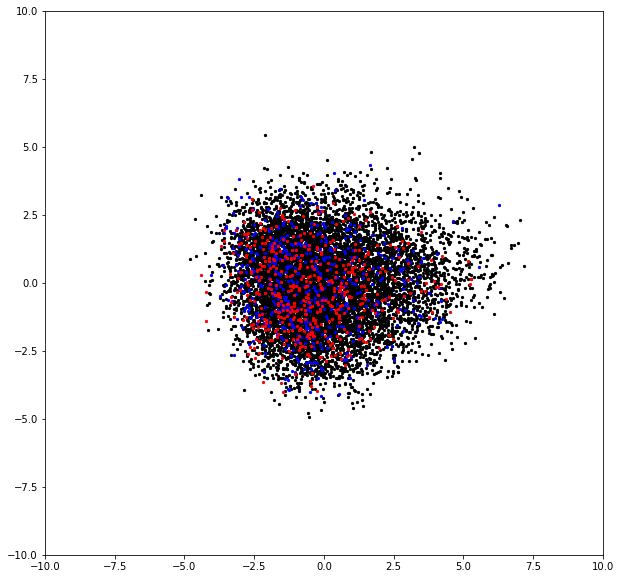

In [25]:
plt.figure(figsize=(10,10))
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.scatter(train_pca_df['x'], train_pca_df['y'], s=5, color = 'black')
plt.scatter(test_pca_df_true['x'], test_pca_df_true['y'], s=5, color = 'blue')
plt.scatter(test_pca_df_false['x'], test_pca_df_false['y'], s=5, color = 'red')
plt.savefig('./'+TF_name+'.png')